In [24]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
!gdown --id 12DrsQ7DNgL4gk7B7jXTTPnlXICaeI8aH
!gdown --id 1YgMblFuaMBxXuJoNT9KXj411l9RdAWmG

Mounted at /content/gdrive/
Downloading...
From: https://drive.google.com/uc?id=12DrsQ7DNgL4gk7B7jXTTPnlXICaeI8aH
To: /content/hour.csv
100% 1.16M/1.16M [00:00<00:00, 51.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YgMblFuaMBxXuJoNT9KXj411l9RdAWmG
To: /content/Readme.txt
100% 5.61k/5.61k [00:00<00:00, 4.57MB/s]


 # Dependencies

In [2]:
!pip install --upgrade scikit-learn
!pip install --upgrade plotly
!pip install hyperopt

     |████████████████████████████████| 23.1 MB 1.6 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 23.9 MB 1.4 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial

In [5]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, PowerTransformer

In [6]:
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression, PoissonRegressor, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

In [7]:
from statsmodels.stats.stattools import durbin_watson

In [8]:
'''Plotly visualization .'''
import plotly.graph_objs as go

# Support

In [9]:
def distribution_plot(data, target_col):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    #histogram and normal probability plot
    sns.distplot(data.loc[:, target_col], fit=norm, ax=axes[0]);
    res = stats.probplot(data.loc[:, target_col], plot=axes[1])
    plt.tight_layout()
    plt.show()

    #skewness and kurtosis
    print("Skewness: %f" % data.loc[:, target_col].skew())
    print("Kurtosis: %f" % data.loc[:, target_col].kurt(), "\n")

    k2, p = stats.normaltest(data.loc[:, target_col])
    print("null hypothesis: x comes from a normal distribution")
    print(f"p_value = {p}, {k2}")

In [ ]:
def resid_analysis(resid):
    x_fit = np.linspace(resid.min(), resid.max(), len(resid))
    loc_laplace, scale_laplace = stats.laplace.fit(resid)
    loc_norm, scale_norm = norm.fit(resid)
    print(f"Fitting of residuals by Laplace distribution: fitted mean = {loc_laplace:.3f}, fitted std = {scale_laplace:.3f}")
    print(f"Fitting of residuals by Normal distribution: fitted mean = {loc_norm:.3f}, fitted std = {scale_norm:.3f}")
    y_fit_laplace = stats.laplace.pdf(x_fit, loc_laplace, scale_laplace)
    y_fit_norm = stats.norm.pdf(x_fit, loc_norm, scale_norm)

    plt.subplots(1, 2, figsize=(25, 5))

    plt.subplot(1, 2, 1)
    plt.plot(resid, '-')
    plt.grid(linestyle=':', color='k')
    plt.title("Residuals")

    plt.subplot(1, 2, 2)
    sns.distplot(resid, bins=100, vertical=True, label="distribution of residuals")
    plt.plot(y_fit_laplace, x_fit, '-b', 
            label=f"approximation by Laplace distribution:\n  fitted mean = {loc_laplace:.4g}, fitted std = {scale_laplace:.4g}")
    plt.plot(y_fit_norm, x_fit, '-g', 
            label=f"approximation by normal distribution:\n  fitted mean = {loc_norm:.4g}, fitted std = {scale_norm:.4g}")
    plt.legend()
    # plt.ylim(resid-0.02*y_range, y_max+0.02*y_range)
    plt.title("Distribution of residuals")
    plt.grid(linestyle=':', color='k')

    plt.tight_layout()
    plt.show()

In [10]:
def dist_graph(data, target_col):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    #histogram and normal probability plot
    sns.distplot(data.loc[:, target_col], fit=norm, ax=axes[0]);
    res = stats.probplot(data.loc[:, target_col], plot=axes[1])
    plt.tight_layout()
    plt.show()

    #skewness and kurtosis
    print("Skewness: %f" % data.loc[:, target_col].skew())
    print("Kurtosis: %f" % data.loc[:, target_col].kurt(), "\n")

    k2, p = stats.normaltest(data.loc[:, target_col])
    alpha = 1e-3
    print("null hypothesis: x comes from a normal distribution")
    print(f"p_value = {p}, {k2}")
    if p < alpha:  # 
        print("The null hypothesis can be rejected")
        print("Oops, We shoukd try to transform the distribution!")
    else:
        print("The null hypothesis cannot be rejected")
        return data.loc[:, target_col], 1

    if p < alpha:
        data.loc[:, target_col+'_box'], lmbda = stats.boxcox(data.loc[:, target_col])
        fig, axes = plt.subplots(1, 2, figsize=(15,5))
        sns.distplot(data.loc[:, target_col+'_box'], fit=norm, ax=axes[0]);
        res = stats.probplot(data.loc[:, target_col+'_box'], plot=axes[1])
        plt.tight_layout()
        plt.show()

        #skewness and kurtosis
        print("Skewness: %f" % data.loc[:, target_col+'_box'].skew())
        print("Kurtosis: %f" % data.loc[:, target_col+'_box'].kurt(), "\n")

        k2, p = stats.normaltest(data.loc[:, target_col+'_box'])
        alpha = 1e-3
        print("null hypothesis: x comes from a normal distribution")
        print(f"p_value = {p}, {k2}")
        if p < alpha:  # 
            print("The null hypothesis still can be rejected")
            print("But we did our best")
        else:
            print("The null hypothesis cannot be rejected now")
    return data.loc[:, target_col+'_box'], lmbda

In [11]:
def best_pipeline(cont_vars, ordinal_vars):

    pipeline_cont = Pipeline(steps=[
                                ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, cont_vars])),
                                ('scaler', StandardScaler())
                                ])
    
    pipeline_ordinal = Pipeline(steps=[
                              ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, ordinal_vars]))
                              ])
    
    feature_union = FeatureUnion(transformer_list = [
                                                     ("pipeline_cont", pipeline_cont),
                                                     ("pipeline_ordinal", pipeline_ordinal)
                                                    ]
                                 )
    
    estimator = Pipeline(steps = [
                                  ('feature_processing', feature_union),
                                  ('model_fitting', LGBMRegressor(random_state=42)) 
                                  ]
                                 )
    return estimator

In [12]:
def pipeline(cont_vars, ordinal_vars, model_type):

    models_dict = {"lgbm": LGBMRegressor(random_state=42), 
                   "RFR": RandomForestRegressor(random_state=42), 
                   "TreeReg": DecisionTreeRegressor(),
                   "SVM": SVR(),
                   "ElasticNet": ElasticNet(random_state=42),
                   "Ridge": Ridge(random_state=42),
                   "Lasso": Lasso(random_state=42),
                   "LinearReg": LinearRegression(),
                   "KNN": KNeighborsRegressor(), 
                   "Poisson": PoissonRegressor()}

    pipeline_cont = Pipeline(steps=[
                                ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, cont_vars])),
                                ('scaler', StandardScaler())
                                ])
    
    pipeline_ordinal = Pipeline(steps=[
                              ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, ordinal_vars]))
                              ])
    
    feature_union = FeatureUnion(transformer_list = [
                                                     ("pipeline_cont", pipeline_cont),
                                                     ("pipeline_ordinal", pipeline_ordinal)
                                                    ]
                                 )
    
    estimator = Pipeline(steps = [
                                  ('feature_processing', feature_union),
                                  ('model_fitting', models_dict[model_type]) 
                                  ]
                                 )
    return estimator

In [13]:
def tuned_pipeline(cont_vars, ordinal_vars, model_type):

    models_dict = {"lgbm": LGBMRegressor(random_state=42, min_child_samples=20, n_estimators=350, 
                                         num_leaves=10, reg_alpha=0.5, reg_lambda=1.25), 
                   "RFR": RandomForestRegressor(random_state=42, max_depth=10, max_features="auto", 
                                                min_samples_split=6, n_estimators=125), 
                   "TreeReg": DecisionTreeRegressor(max_depth=7, max_features="auto", min_samples_split=4),
                   "SVM": SVR(C=1, gamma=0.055),
                   "ElasticNet": ElasticNet(random_state=42),
                   "Ridge": Ridge(random_state=42, alpha=0.1),
                   "Lasso": Lasso(random_state=42),
                   "LinearReg": LinearRegression(),
                   "KNN": KNeighborsRegressor(n_neighbors=10, weights="uniform"), 
                   "Poisson": PoissonRegressor()}

    pipeline_cont = Pipeline(steps=[
                                ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, cont_vars])),
                                ('scaler', StandardScaler())
                                ])
    
    pipeline_ordinal = Pipeline(steps=[
                              ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, ordinal_vars]))
                              ])
    
    feature_union = FeatureUnion(transformer_list = [
                                                     ("pipeline_cont", pipeline_cont),
                                                     ("pipeline_ordinal", pipeline_ordinal)
                                                    ]
                                 )
    
    estimator = Pipeline(steps = [
                                  ('feature_processing', feature_union),
                                  ('model_fitting', models_dict[model_type]) 
                                  ]
                                 )
    return estimator

In [14]:
def scatter_plot(x, y, title, xaxis, yaxis, size, c_scale):
    trace = go.Scatter(
    x = x,
    y = y,
    mode = 'markers',
    marker = dict(color = y, size = size, showscale = True, colorscale = c_scale))
    layout = go.Layout(width=1000, height=500, hovermode= 'closest', title = title, xaxis = dict(title = xaxis), yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], layout = layout)
    return fig.show()

In [15]:
def quality_func(estimators_list, y_transformer, y_train, y_test, x_train, x_test):
        
    quality_frame = pd.DataFrame(columns=["r2_score_train", "r2_score_test", 
                                            "mae_train", "mae_test"], 
                                index = types)
    for estimator, type_ in zip(estimators_list, types):
        if type_ not in  ['Poisson', "lgbm", "TreeReg", "RFR"]:
            estimator.fit(x_train, y_transformer.transform(y_train))
            model_predictions_train = y_transformer.inverse_transform(estimator.predict(x_train).reshape(-1,1))
            model_predictions_test = y_transformer.inverse_transform(estimator.predict(x_test).reshape(-1,1))
        else:
            estimator.fit(x_train, y_train)
            model_predictions_train = estimator.predict(x_train).reshape(-1,1)
            model_predictions_test = estimator.predict(x_test).reshape(-1,1)
        # r2
        r2_score_train = np.round(r2_score(y_train, model_predictions_train), 4)
        r2_score_test = np.round(r2_score(y_test, model_predictions_test), 4)
        # mae
        mae_train = np.round(mean_absolute_error(y_train, model_predictions_train), 4)
        mae_test = np.round(mean_absolute_error(y_test, model_predictions_test), 4)

        quality_frame.loc[type_, ["r2_score_train", "r2_score_test", 
                                    "mae_train", "mae_test"]] = [r2_score_train, r2_score_test, mae_train, mae_test]

    scatter_plot(quality_frame.index, quality_frame['mae_test'], title='Mae Test Score', 
                    xaxis='Models', yaxis='Mae Test Score', size=30, c_scale='Rainbow')
    return quality_frame

In [16]:
def func_res(estimator, x_train, x_test, y_train, y_test, dates, y_transformer):
    quality_frame = pd.DataFrame(columns=["r2_score_train", "r2_score_test", "mae_train", "mae_test"])
    # I'm doing y transformation just for better residuals visualisation
    estimator.fit(x_train, y_transformer.transform(y_train))
    model_predictions_train = y_transformer.inverse_transform(estimator.predict(x_train).reshape(-1,1))
    model_predictions_test = y_transformer.inverse_transform(estimator.predict(x_test).reshape(-1,1))

    # r2
    r2_score_train = np.round(r2_score(y_train, model_predictions_train), 4)
    r2_score_test = np.round(r2_score(y_test, model_predictions_test), 4)
    # mae
    mae_train = np.round(mean_absolute_error(y_train, model_predictions_train), 4)
    mae_test = np.round(mean_absolute_error(y_test, model_predictions_test), 4)

    quality_frame.loc[0, ["r2_score_train", "r2_score_test","mae_train", "mae_test"]] = [r2_score_train, r2_score_test, mae_train, mae_test]

    dates_train, dates_test = dates.iloc[:int(len(dates)*0.5)], dates.iloc[int(len(dates)*0.5):]

    dates_train["y_real"] = y_train
    dates_train["y_predictions"] = model_predictions_train
    dates_train["residuals"] = dates_train["y_predictions"] - dates_train["y_real"]

    dates_test["y_real"] = y_test
    dates_test["y_predictions"] = model_predictions_test
    dates_test["residuals"] = dates_test["y_predictions"] - dates_test["y_real"]
    
    traindurbinWatson = durbin_watson(dates_train['residuals'])
    testdurbinWatson = durbin_watson(dates_test['residuals'])

    print(quality_frame)

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    sns.scatterplot(x="y_real", y="y_predictions", data=dates_train, ax=axes[0])
    sns.scatterplot(x="y_real", y="y_predictions", data=dates_test, ax=axes[1])
    axes[0].plot([0, 600], [0, 600], "r")
    axes[1].plot([0,1000], [0, 1000], "r")
    axes[0].set_title("Train set")
    axes[1].set_title("Test set")
    plt.show()

    print(f"DurbinWatson coef for train = {traindurbinWatson:0.03}")
    print(f"DurbinWatson coef for test = {testdurbinWatson:0.03}")
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    sns.scatterplot(x="dteday", y="residuals", data=dates_train, ax=axes[0])
    sns.scatterplot(x="dteday", y="residuals", data=dates_test, ax=axes[1])
    axes[0].set_title("Train set")
    axes[1].set_title("Test set")
    plt.show()

In [17]:
def objective(space, estimator, x_train, y_train, model_type, y_transformer):
    for element in ['model_fitting__num_leaves', 'model_fitting__min_child_samples', 'model_fitting__n_estimators',
                    'model_fitting__max_depth', 'model_fitting__min_samples_split']:
        if element in space:
            space[element] = int(space[element])

    time_split = TimeSeriesSplit(n_splits=5)

    # задаём модели требуемые параметры    
    estimator.set_params(**space)

    if model_type not in  ['Poisson', "lgbm", "TreeReg", "RFR"]:
        # We'll get a little leak here
        y_train = y_transformer.transform(y_train)

    score = cross_val_score(estimator, x_train, y_train, scoring='neg_mean_absolute_error', cv=time_split).mean()
    print("MAE {:.3f} params {}".format(-score, space))
    return {'loss':-score, 'status': STATUS_OK }

In [18]:
def space_optimizer(model_type, estimator, x_data, y_data, y_transformer):
    if model_type == "lgbm":
        space = {
            'model_fitting__reg_alpha': hp.loguniform('reg_alpha', -1*np.log(10), 2*np.log(10)),
            'model_fitting__reg_lambda': hp.loguniform('reg_lambda', -1*np.log(10), 2*np.log(10)),
            'model_fitting__num_leaves': hp.quniform('num_leaves', 10, 60, 1),
            'model_fitting__min_child_samples': hp.quniform('min_child_samples', 20, 150, 1),
            'model_fitting__n_estimators': hp.quniform('n_estimators', 300, 800, 1)
            }
        evals = 200

    elif model_type == "TreeReg":
        space = {
            'model_fitting__max_depth': hp.quniform('max_depth', 5, 50, 1),
            'model_fitting__max_features': hp.choice('max_features', ["auto", "sqrt", "log2"]),
            'model_fitting__min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
            }
        evals = 150
            
    elif model_type == "RFR":
        space = {
            'model_fitting__max_depth': hp.quniform('max_depth', 5, 100, 5),
            'model_fitting__max_features': hp.choice('max_features', ["auto", "sqrt", "log2"]),
            'model_fitting__min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
            'model_fitting__n_estimators': hp.quniform('n_estimators', 100, 500, 25),
            }
        evals = 50
            
    elif model_type == "SVM":
        space = {
            'model_fitting__gamma': hp.loguniform('gamma', -4*np.log(10), 0*np.log(10)),
            'model_fitting__C': hp.loguniform('C', -1*np.log(10), 2*np.log(10)),
            }
        evals = 10 # 50 i have no time for paramter tuning for that model it's too clow 
            
    elif model_type == "Ridge":
        space = {
            'model_fitting__alpha': hp.loguniform('alpha', -4*np.log(10), 4*np.log(10)),
            }
        evals = 75
    
    elif model_type == "KNN":
        space = {
            'model_fitting__n_neighbors': hp.choice('n_neighbors', [3, 5, 7, 10]),
            'model_fitting__weights': hp.choice('weights', ["uniform", "distance"]),
            }
        evals = 75

    trials = Trials()

    best = fmin(
        # функция для оптимизации 
        fn=partial(objective, estimator=estimator, x_train=x_data, y_train=y_data, model_type=model_type, y_transformer=y_transformer),
        # пространство поиска гиперпараметров
        space=space,
        # алгоритм поиска
        algo=tpe.suggest,
        # число итераций
        max_evals=evals,
        # куда сохранять историю поиска
        trials=trials,
        # random state
        rstate=np.random.RandomState(1),
        # progressbar
        show_progressbar=True
        )
    return best

In [19]:
def models_optimization(estimators_list, models_types, x_train, y_train, y_transformer):
    for estimator, type_ in zip(enumerate(estimators_list), models_types):
        number, estimator = estimator

        # check model type
        if type_ in ["lgbm", "KNN", "TreeReg", "RFR", "SVM", "Ridge"]:
            print(f"optimization of {type_} model")
            # make optimization
            best_params = space_optimizer(model_type=type_, estimator=estimator, x_data=x_train, y_data=y_train.values, y_transformer=y_transformer)
            # some params should be integer
            for element in ['model_fitting__num_leaves', 'model_fitting__min_child_samples', 'model_fitting__n_estimators',
                            'model_fitting__max_depth', 'model_fitting__min_samples_split']:
                if element in best_params:
                    best_params[element] = int(best_params[element])
            print(f"best params for model {type_} is {best_params}\n")
            estimators_list[number].named_steps["model_fitting"].set_params(**best_params)
        else:
            print(f"\nOptimization of the {type_} model is not required\n")
    return estimators_list

# Task and Criterations

## Dataset Description

In [ ]:
!cat Readme.txt

Bike Sharing Dataset

Hadi Fanaee-T

Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Porto
INESC Porto, Campus da FEUP
Rua Dr. Roberto Frias, 378
4200 - 465 Porto, Portugal


Background 

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return 
back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return 
back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of 
over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, 
environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by
these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration
of tra

## To-do:  
- EDA (2 points)  

- Preprocessing (1 point) 

- Use different advanced regression algorithms and select the best one:  
    - KNN Regressor (1 point)  
    - Decision Tree Regressor (1 point)  
    - Random Forest (1 point)  
    - SVM Regressor (1 point)  
    - Boosting Regressor - any Boosting algorithm with Regression (1 point)  
  
Warning! The task is considered to be done for each model if a hyperparameter tuning was performed and the quality is measured on a test sample.  

- Considering the best model, train it on the first year and validate on the second year. The results are better or worse? Why? (1 point)  

- Considering the best model, train it on the first year with multitarget (casual, registered) and validate on the second year. Analyze both targets independently. Then use a sum of both targets to predict cnt on the second year. Estimate the quality. Are the results better or worse in comparison with the previous step? Why? (1 point)  

- During your research, please answer the following questions:
    - What are the most influential features? (1 point)
    - How the temperature and humidity affect rental count rates? (1 point)
    - What is more important: current season or current hour, temperature or feeling temperature? Why? (1 point)

Total points 13 + 3 for additional research which is not included in the criteria.

# EDA

In [ ]:
data = pd.read_csv("hour.csv", index_col="instant")
data.loc[:, "dteday"] = pd.to_datetime(data.loc[:, "dteday"])

## Type transformations

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      17379 non-null  datetime64[ns]
 1   season      17379 non-null  int64         
 2   yr          17379 non-null  int64         
 3   mnth        17379 non-null  int64         
 4   hr          17379 non-null  int64         
 5   holiday     17379 non-null  int64         
 6   weekday     17379 non-null  int64         
 7   workingday  17379 non-null  int64         
 8   weathersit  17379 non-null  int64         
 9   temp        17379 non-null  float64       
 10  atemp       17379 non-null  float64       
 11  hum         17379 non-null  float64       
 12  windspeed   17379 non-null  float64       
 13  casual      17379 non-null  int64         
 14  registered  17379 non-null  int64         
 15  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), 

As was said in the description, such variables as "season", "yr", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit" are categorical, so lets transform them

In [ ]:
Сategories = ["season", "yr", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit"]
for var in Сategories:
    data.loc[:, var] = data.loc[:, var].astype("category")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      17379 non-null  datetime64[ns]
 1   season      17379 non-null  category      
 2   yr          17379 non-null  category      
 3   mnth        17379 non-null  category      
 4   hr          17379 non-null  category      
 5   holiday     17379 non-null  category      
 6   weekday     17379 non-null  category      
 7   workingday  17379 non-null  category      
 8   weathersit  17379 non-null  category      
 9   temp        17379 non-null  float64       
 10  atemp       17379 non-null  float64       
 11  hum         17379 non-null  float64       
 12  windspeed   17379 non-null  float64       
 13  casual      17379 non-null  int64         
 14  registered  17379 non-null  int64         
 15  cnt         17379 non-null  int64         
dtypes: category(8), dateti

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000
atemp,17379.0,0.475775,0.171850,0.00,0.3333,0.4848,0.6212,1.0000
hum,17379.0,0.627229,0.192930,0.00,0.4800,0.6300,0.7800,1.0000
windspeed,17379.0,0.190098,0.122340,0.00,0.1045,0.1940,0.2537,0.8507
casual,17379.0,35.676218,49.305030,0.00,4.0000,17.0000,48.0000,367.0000
registered,17379.0,153.786869,151.357286,0.00,34.0000,115.0000,220.0000,886.0000
cnt,17379.0,189.463088,181.387599,1.00,40.0000,142.0000,281.0000,977.0000


## Missing values analysis

Okay, here we've got no missing values

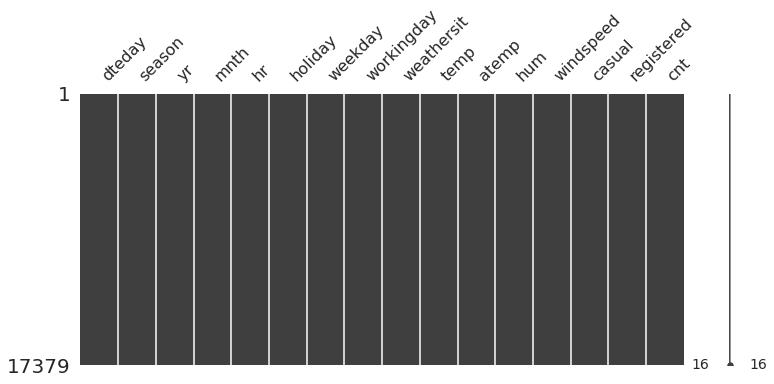

In [ ]:
msno.matrix(data, figsize=(12,5))
plt.show()

## Target variables analysis

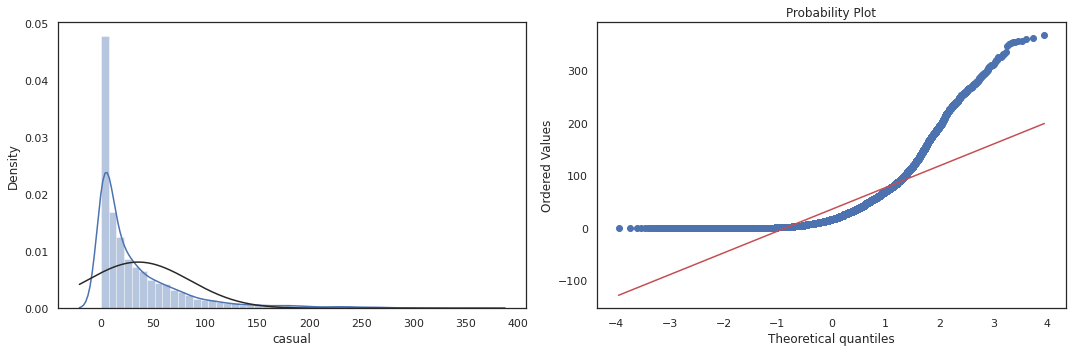

Skewness: 2.499237
Kurtosis: 7.571002 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 9087.787995373532


In [ ]:
distribution_plot(data, target_col="casual")

As we can see skewness of "casual"'s distribution is pretty high, it could be a good idea to perform box-cox transformation to make it more "normal", but we got a lot of zero observations

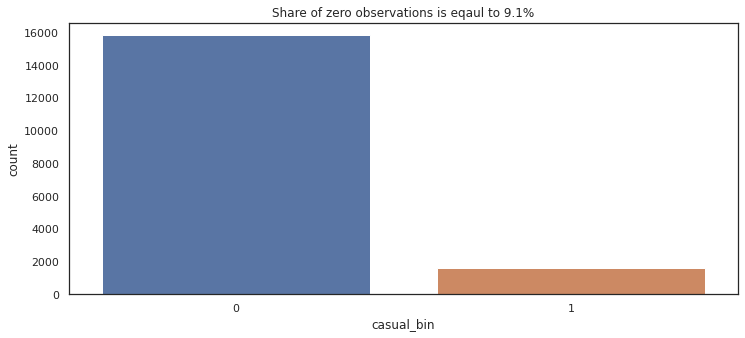

In [ ]:
data.loc[:, "casual_bin"] = 1
data.loc[data["casual"]>0, "casual_bin"] = 0
plt.figure(figsize=(12,5))
sns.countplot(data=data, x="casual_bin")
plt.title(f"Share of zero observations is eqaul to {data.loc[:, 'casual_bin'].mean()*100:0.02}%")
plt.show()

There are several ways how we can deal with it:
- The easiest way is just to replace zero observation with small values, for example to 10e-4. It gives us an opportunity to apply box-cox transformation. But anyway the distribution will be far from normal
- We can separate the task into 2 parts. First of all, we could fit log reg to predict whether the count will be 0 or not. And if not we could fit regression and apply a box-cox transformation to non-zero values.
- And the last one is to fit regression with another error distribution assumption  
I will try the first and the third ones, and if I have time, I will try the second options.

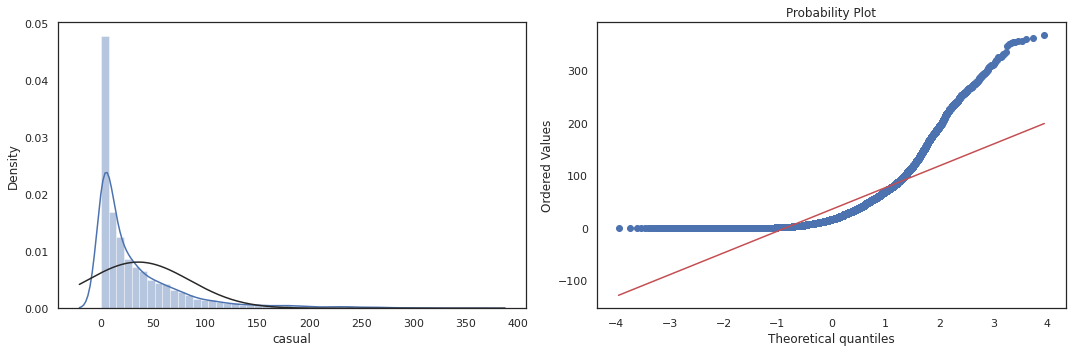

Skewness: 2.499311
Kurtosis: 7.571354 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 9088.06368419449
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


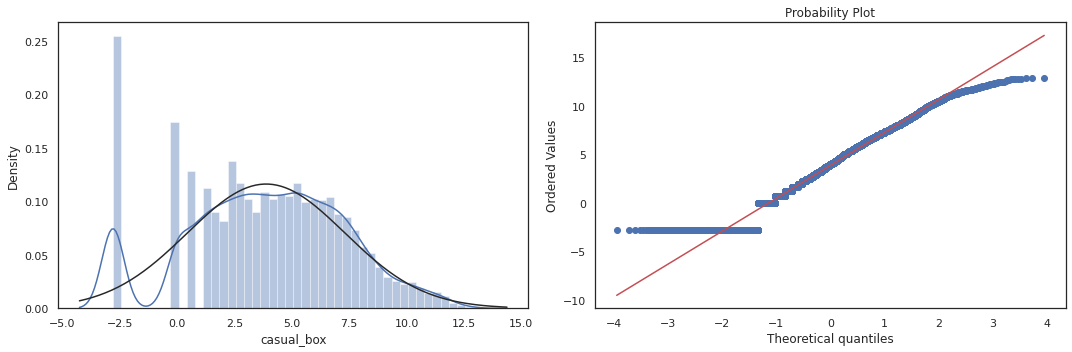

Skewness: -0.145147
Kurtosis: -0.405056 

null hypothesis: x comes from a normal distribution
p_value = 3.642545796145718e-55, 250.69899456588143
The null hypothesis still can be rejected
But we did our best


In [ ]:
data.loc[data["casual_bin"]==1, 'casual'] = 10e-3
data.loc[:, 'casual_box'], lmbda_casual = dist_graph(data.copy(), target_col='casual')

Okay, better but far from perfect.  
A similar situation is observed in other cases.

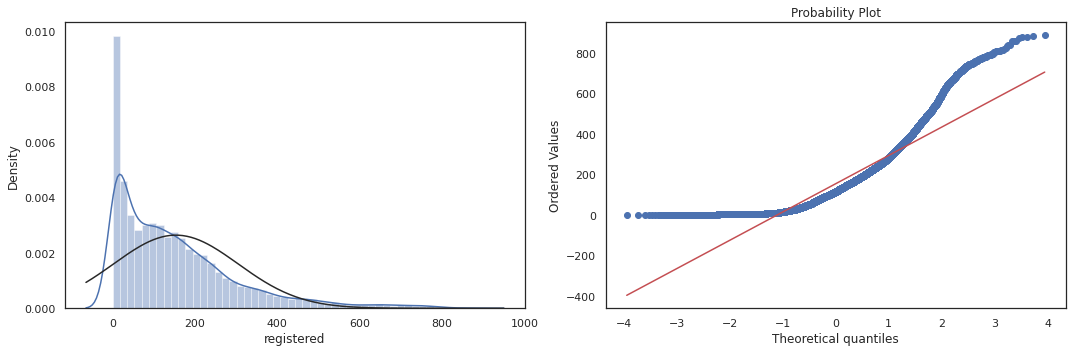

Skewness: 1.557904
Kurtosis: 2.750018 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 4926.61356426601


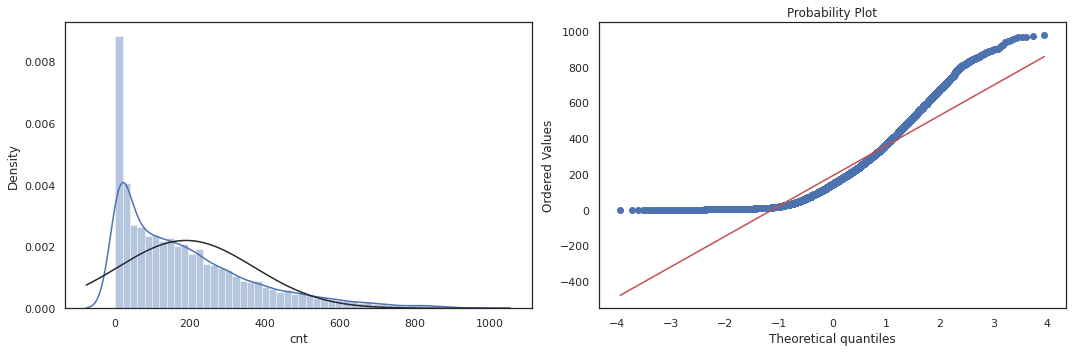

Skewness: 1.277412
Kurtosis: 1.417203 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 3459.8319080485744


In [ ]:
distribution_plot(data, target_col="registered")
distribution_plot(data, target_col="cnt")

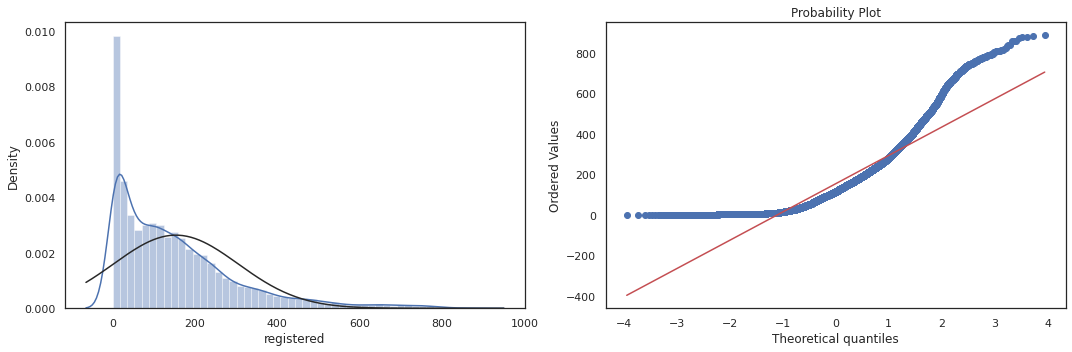

Skewness: 1.557905
Kurtosis: 2.750019 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 4926.615407989791
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


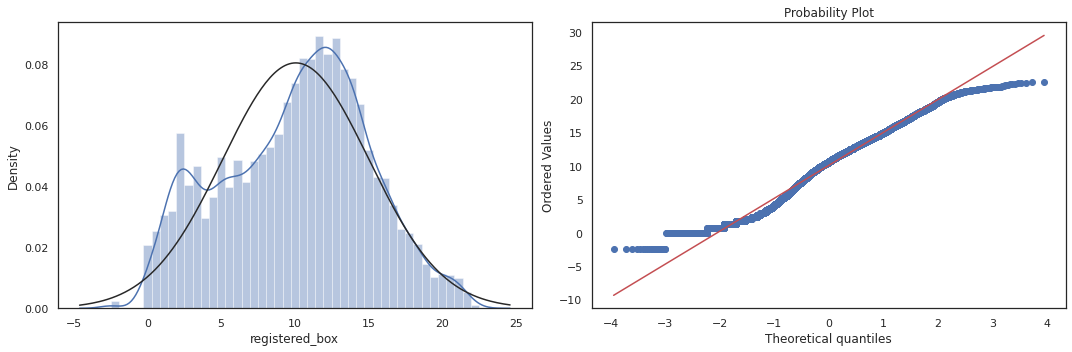

Skewness: -0.129515
Kurtosis: -0.665962 

null hypothesis: x comes from a normal distribution
p_value = 2.7921974698862684e-180, 826.876975658985
The null hypothesis still can be rejected
But we did our best


In [ ]:
data.loc[data["registered"] == 0, "registered"] = 10e-3
data.loc[:, 'registered_box'], lmbda_casual = dist_graph(data.copy(), target_col='registered')

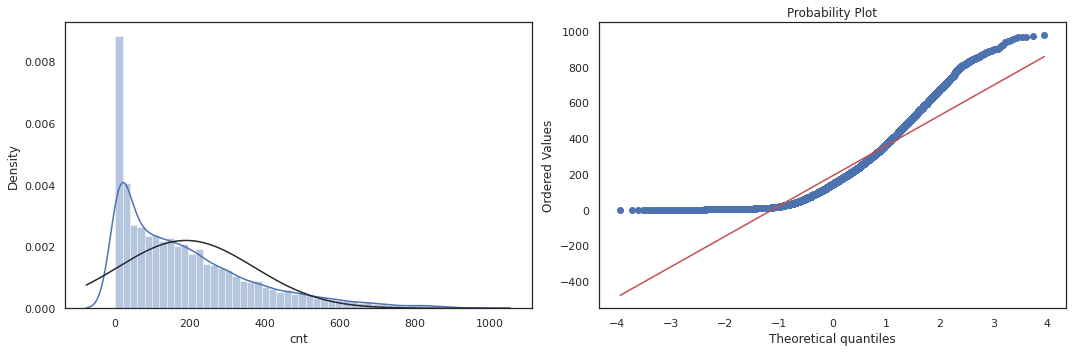

Skewness: 1.277412
Kurtosis: 1.417203 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 3459.8319080485744
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


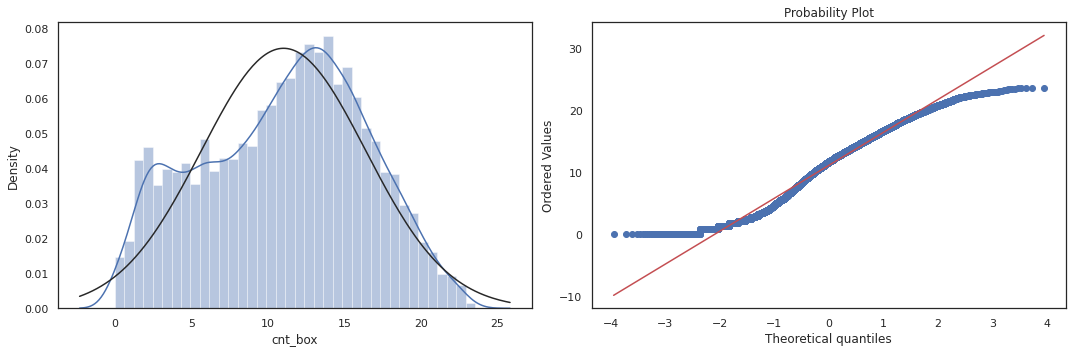

Skewness: -0.147928
Kurtosis: -0.821763 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 1698.430567944998
The null hypothesis still can be rejected
But we did our best


In [ ]:
data.loc[data["cnt"] == 0, "cnt"] = 10e-3
data.loc[:, 'cnt_box'], lmbda_casual = dist_graph(data.copy(), target_col='cnt')

In [ ]:
data.drop(columns=['casual', 'registered', 'cnt', 'casual_bin'], inplace=True)

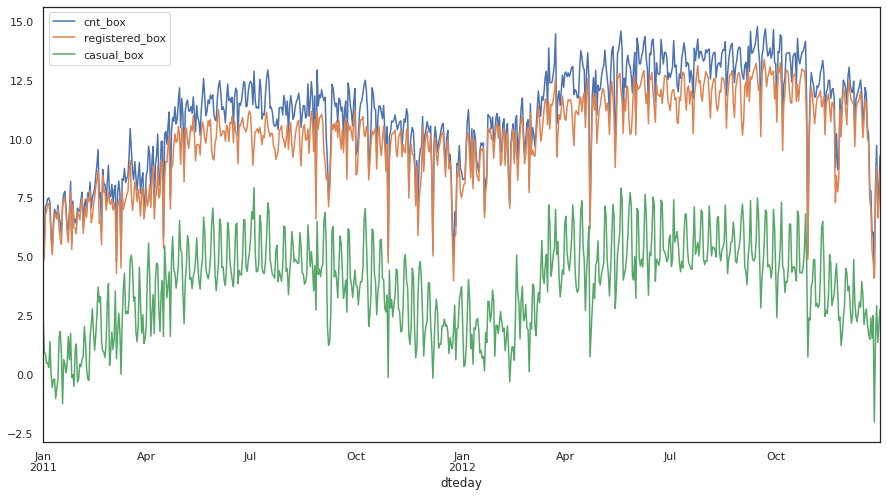

In [ ]:
data.groupby("dteday")["cnt_box", "registered_box", "casual_box"].mean().plot(figsize=(15,8))
plt.show()

## Univariate analysis

### Numerical Features

#### temp

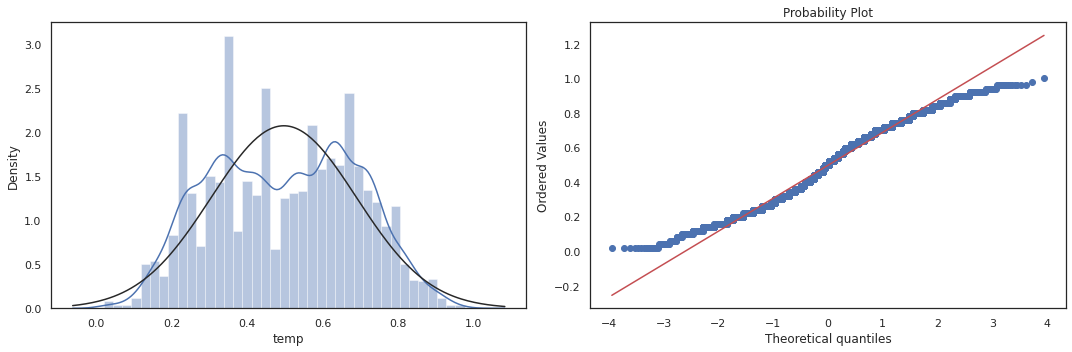

Skewness: -0.006021
Kurtosis: -0.941844 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 2939.4453989959998


In [ ]:
distribution_plot(data, target_col="temp")

#### atemp

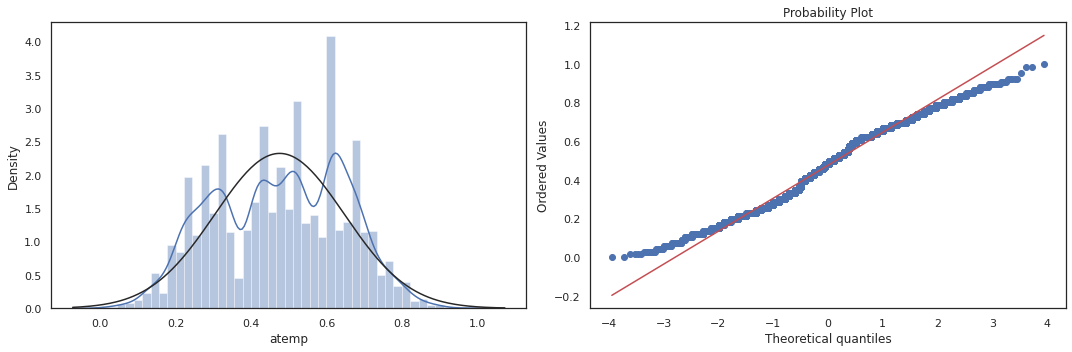

Skewness: -0.090429
Kurtosis: -0.845412 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 1854.8565754560002


In [ ]:
distribution_plot(data, target_col="atemp")

#### hum

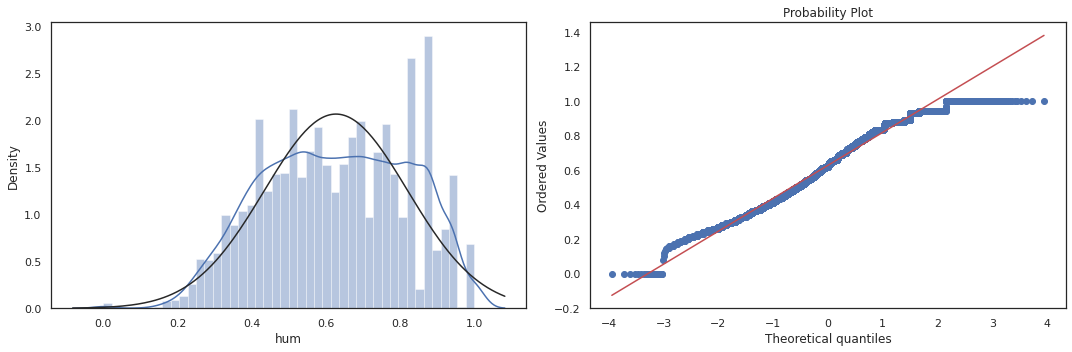

Skewness: -0.111287
Kurtosis: -0.826117 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 1705.6434642713227


In [ ]:
distribution_plot(data, target_col="hum")

#### windspeed

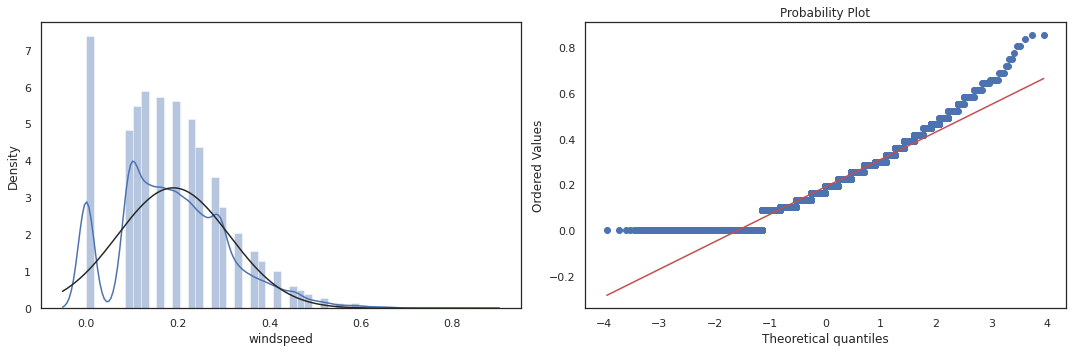

Skewness: 0.574905
Kurtosis: 0.590820 

null hypothesis: x comes from a normal distribution
p_value = 7.800636416690918e-215, 986.0031793429386


In [ ]:
distribution_plot(data, target_col="windspeed")

As we can see here all regressor is distributed pretty normal and there is no need to do any operations with them

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,17379.0,0.496987,0.192556,0.020000,0.340000,0.500000,0.660000,1.000000
atemp,17379.0,0.475775,0.171850,0.000000,0.333300,0.484800,0.621200,1.000000
hum,17379.0,0.627229,0.192930,0.000000,0.480000,0.630000,0.780000,1.000000
windspeed,17379.0,0.190098,0.122340,0.000000,0.104500,0.194000,0.253700,0.850700
casual_box,17379.0,3.875815,3.431193,-2.799662,1.641871,4.042222,6.349970,12.911410
registered_box,17379.0,10.074356,4.966592,-2.482609,6.307107,10.598191,13.617152,22.502329
cnt_box,17379.0,11.031061,5.366500,0.000000,6.827897,11.601122,15.048978,23.535711


We should not forget about normalization  
And now we are going to explore categorical features



### Categorical features

In [ ]:
data.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual_box,registered_box,cnt_box
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,1.255326,3.879086,4.361876
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,2.689292,6.132229,6.827897
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,1.960431,5.658913,6.162337
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,1.255326,3.330427,3.892645
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,-2.799662,0.000000,0.000000


#### season, year, month, hour

Distribution of seasons is balanced. We've got two complete years

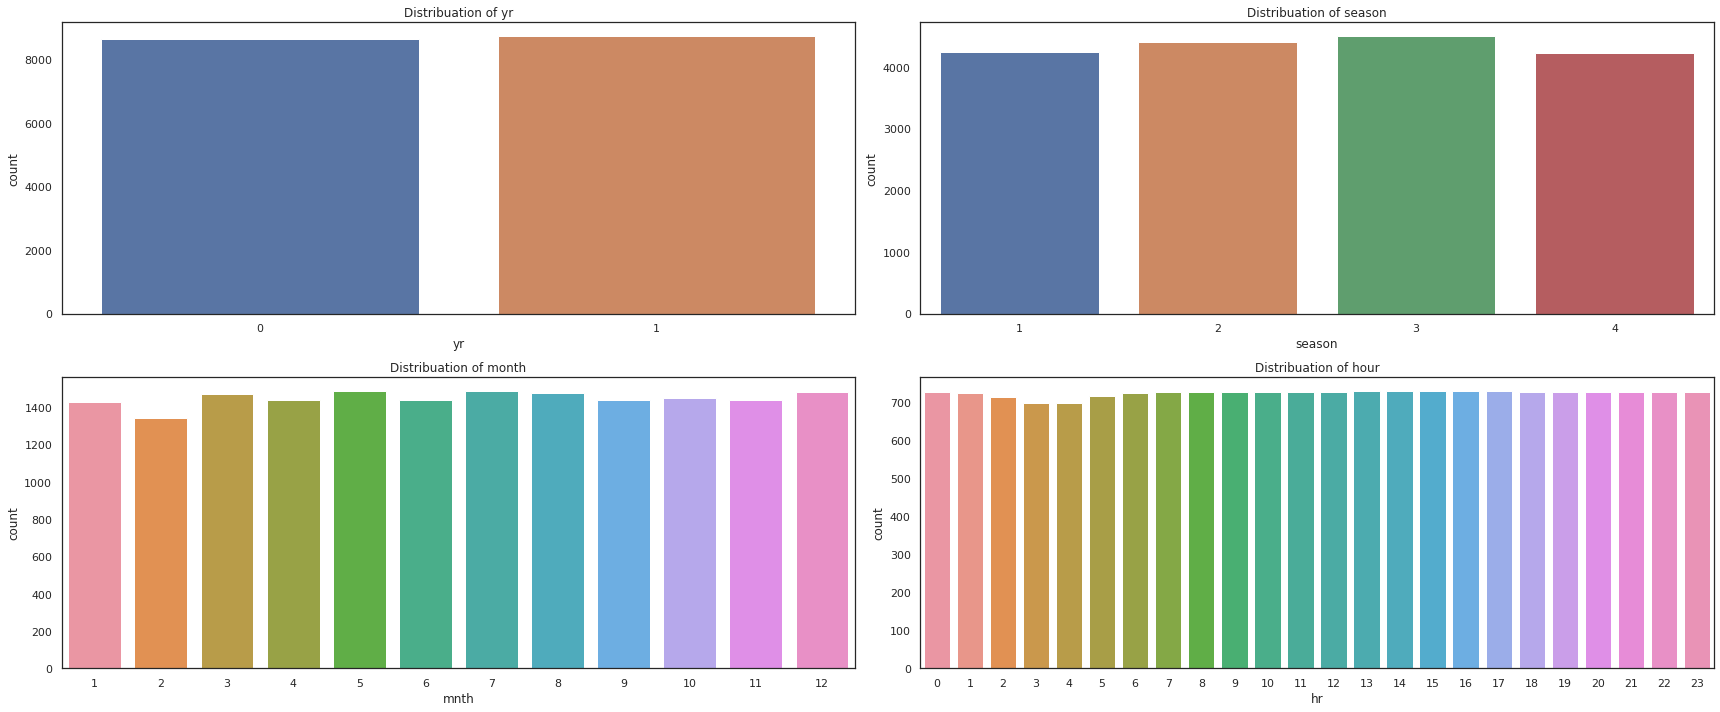

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(24,10))
axes = axes.ravel()
sns.countplot(data=data, x="yr", ax=axes[0])
axes[0].set_title("Distribuation of yr")

sns.countplot(data=data, x="season", ax=axes[1])
axes[1].set_title("Distribuation of season")

sns.countplot(data=data, x="mnth", ax=axes[2])
axes[2].set_title("Distribuation of month")

sns.countplot(data=data, x="hr", ax=axes[3])
axes[3].set_title("Distribuation of hour")
plt.tight_layout()
plt.show()

#### holiday, weekday, workingday

Everything seems to be fine

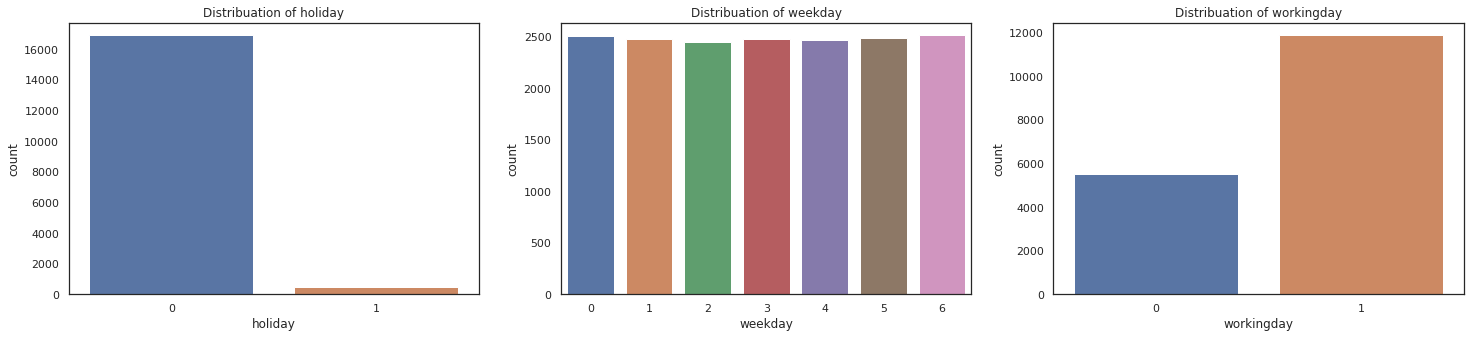

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25,5))
sns.countplot(data=data, x="holiday", ax=axes[0])
axes[0].set_title("Distribuation of holiday")

sns.countplot(data=data, x="weekday", ax=axes[1])
axes[1].set_title("Distribuation of weekday")

sns.countplot(data=data, x="workingday", ax=axes[2])
axes[2].set_title("Distribuation of workingday")
plt.show()

#### weathersit

The fourth category of weather is really rare. I can't say could it be useful or not

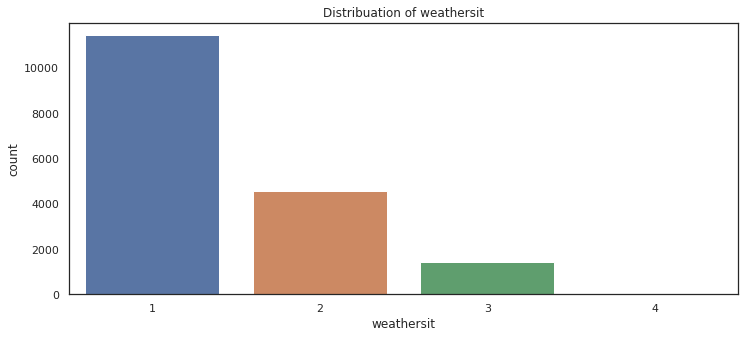

In [ ]:
fig = plt.figure(figsize=(12,5))
sns.countplot(data=data, x="weathersit")
plt.title("Distribuation of weathersit")
plt.show()

## Multivariate analysis

### Numerical Features

There is a high correlation between temp and atemp, so we have to use one of them to fit the model.  
casual, registered, and total count are correlated too, but I have no conclusions on this matter yet. Except for the hypothesis that it could be useful to predict total count, using the sum of predicted casual and registered

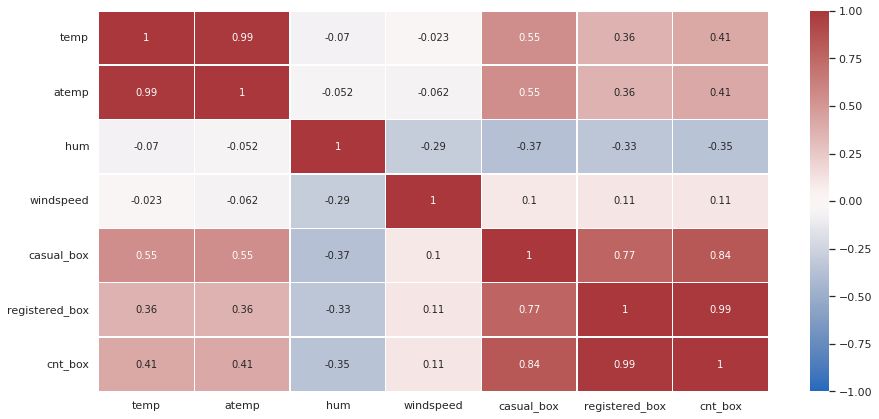

In [ ]:
corr = data.select_dtypes(include=[np.float])
f, ax = plt.subplots(figsize=(15,7))
sns.heatmap(corr.corr(method='pearson'), vmin=-1, vmax=1, linewidths=0.5, cmap = 'vlag', annot=True)
plt.yticks(rotation = 0)
plt.show()

It seems abnormal that wind speed has a positive correlation with the target variable. We should try to measure the quality of the model with and without it.

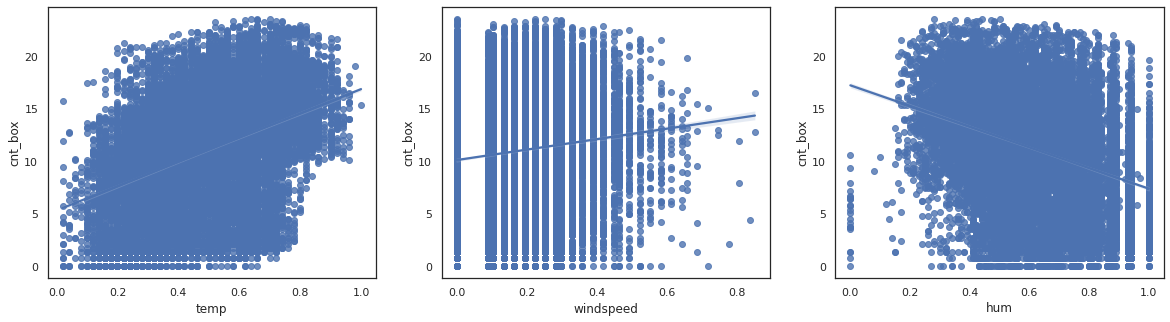

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 5))
sns.regplot(x="temp", y="cnt_box", data=data, ax=ax1)
sns.regplot(x="windspeed", y="cnt_box", data=data, ax=ax2)
sns.regplot(x="hum", y="cnt_box", data=data, ax=ax3)
plt.show()

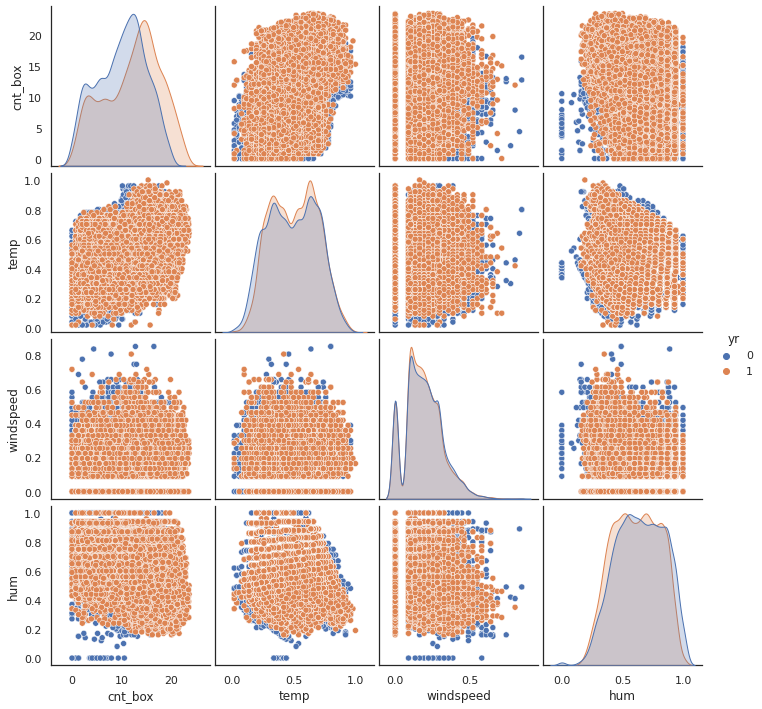

In [ ]:
sns.pairplot(data=data.loc[:, ["yr", "cnt_box", "temp", "windspeed", "hum"]], hue="yr")
plt.show()

### Categorical Features

We will perform categorical multivariate feature analysis using total count feature, as far as it correlated with registered and casual we could ignore them 

#### season, year, hour, month

As we can see in the plot below, there is a significant **difference** between the count of users **in the first year and the second one**. And it seems like we have no features that can help us take this into account in the model. So we can expect that the predictions of our models will be underestimated.
  
Also, we've got such categorical features as "hour". There are too many categories in it, so we have to transform them.
  
A similar issue is encountered with season and months features. They give us the same information but in a different manner. We have to consider an option of removing one of them.

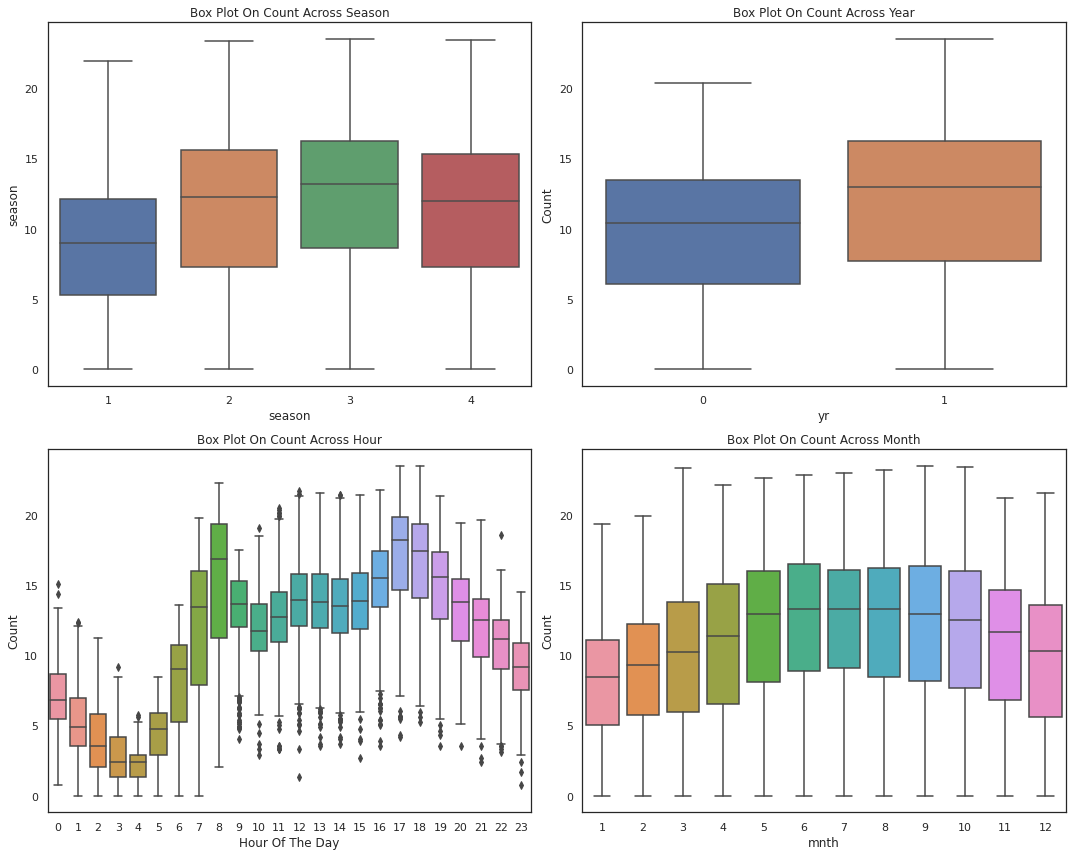

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
sns.boxplot(data=data, y="cnt_box", x="season", orient="v", ax=axes[0][0])
sns.boxplot(data=data, y="cnt_box", x="yr", orient="v", ax=axes[0][1])
sns.boxplot(data=data, y="cnt_box", x="hr", orient="v", ax=axes[1][0])
sns.boxplot(data=data, y="cnt_box", x="mnth", orient="v", ax=axes[1][1])

axes[0][0].set(ylabel='season', title="Box Plot On Count Across Season")
axes[0][1].set(xlabel='yr', ylabel='Count', title="Box Plot On Count Across Year")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count', title="Box Plot On Count Across Hour")
axes[1][1].set(xlabel='mnth', ylabel='Count', title="Box Plot On Count Across Month")
plt.tight_layout()
plt.show()

#### holiday, weekday, workingday, weathersit

Weekday and workingday are pretty similar, and I think we should choose one of them.
  
I think we can keep the fourth category in the weather feature

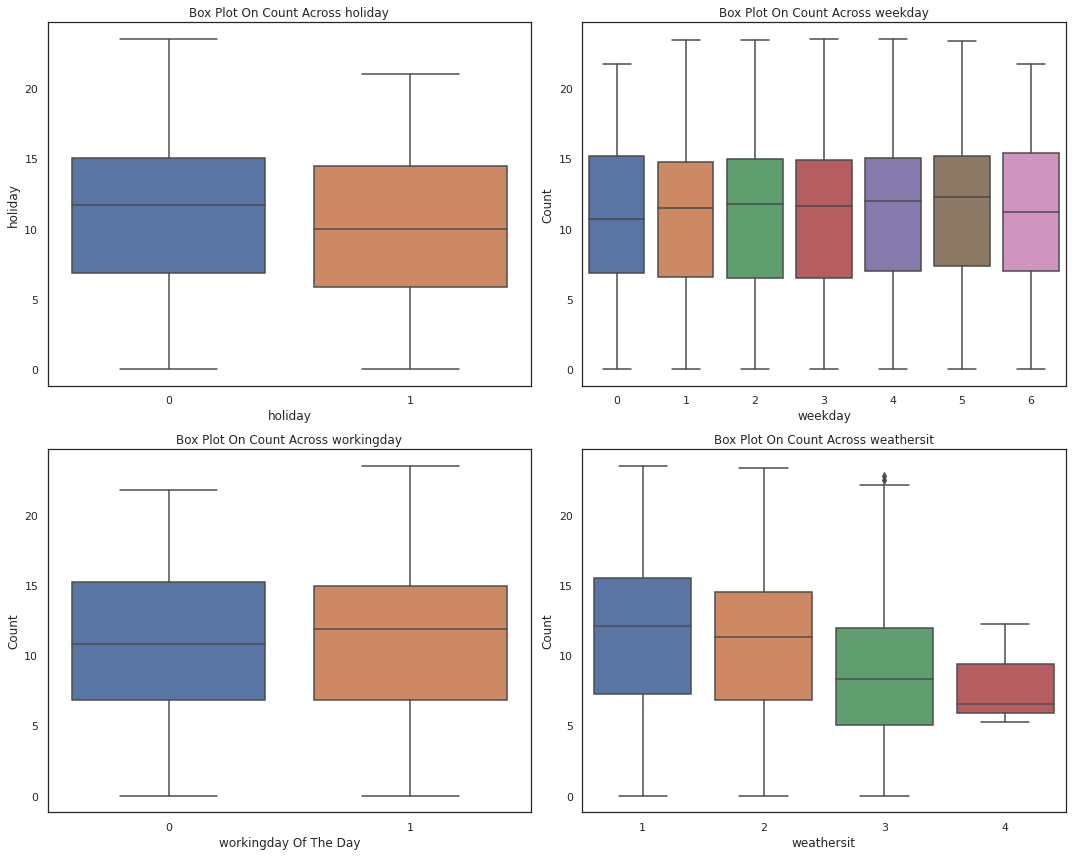

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
sns.boxplot(data=data, y="cnt_box", x="holiday", orient="v", ax=axes[0][0])
sns.boxplot(data=data, y="cnt_box", x="weekday", orient="v", ax=axes[0][1])
sns.boxplot(data=data, y="cnt_box", x="workingday", orient="v", ax=axes[1][0])
sns.boxplot(data=data, y="cnt_box", x="weathersit", orient="v", ax=axes[1][1])

axes[0][0].set(ylabel='holiday', title="Box Plot On Count Across holiday")
axes[0][1].set(xlabel='weekday', ylabel='Count', title="Box Plot On Count Across weekday")
axes[1][0].set(xlabel='workingday Of The Day', ylabel='Count', title="Box Plot On Count Across workingday")
axes[1][1].set(xlabel='weathersit', ylabel='Count', title="Box Plot On Count Across weathersit")
plt.tight_layout()
plt.show()

I think that neither season nor month is not an appropriate choice. We have to construct a new variable using the month feature. 

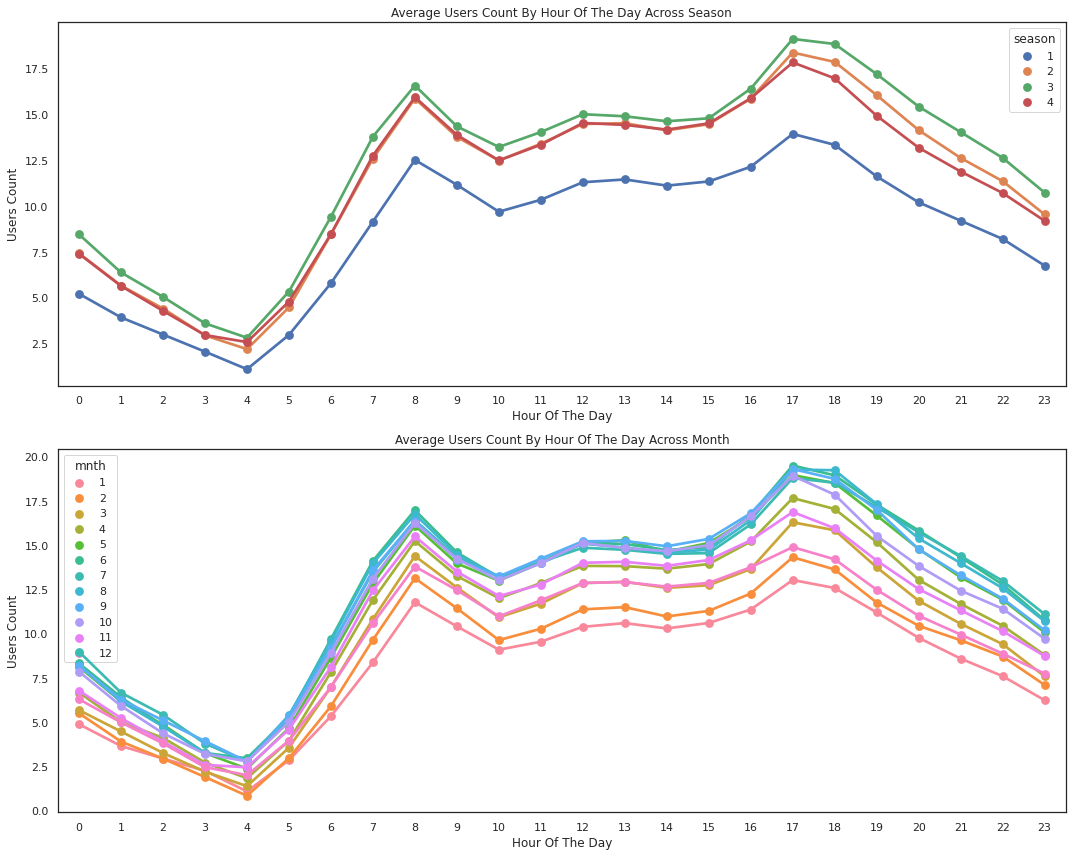

In [ ]:
fig, (ax1, ax2)= plt.subplots(2, 1, figsize=(15,12))

hourAggregated = pd.DataFrame(data.groupby(["hr","season"],sort=True)["cnt_box"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hr"], y=hourAggregated["cnt_box"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax1)
ax1.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(data.groupby(["hr","mnth"],sort=True)["cnt_box"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hr"], y=hourAggregated["cnt_box"], hue=hourAggregated["mnth"], data=hourAggregated, join=True, ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count', title="Average Users Count By Hour Of The Day Across Month", label='big')

plt.tight_layout()
plt.show()

In [ ]:
data.drop(columns=["season"], inplace=True)

I consider that weekday is the excess feature and we should use only working day.

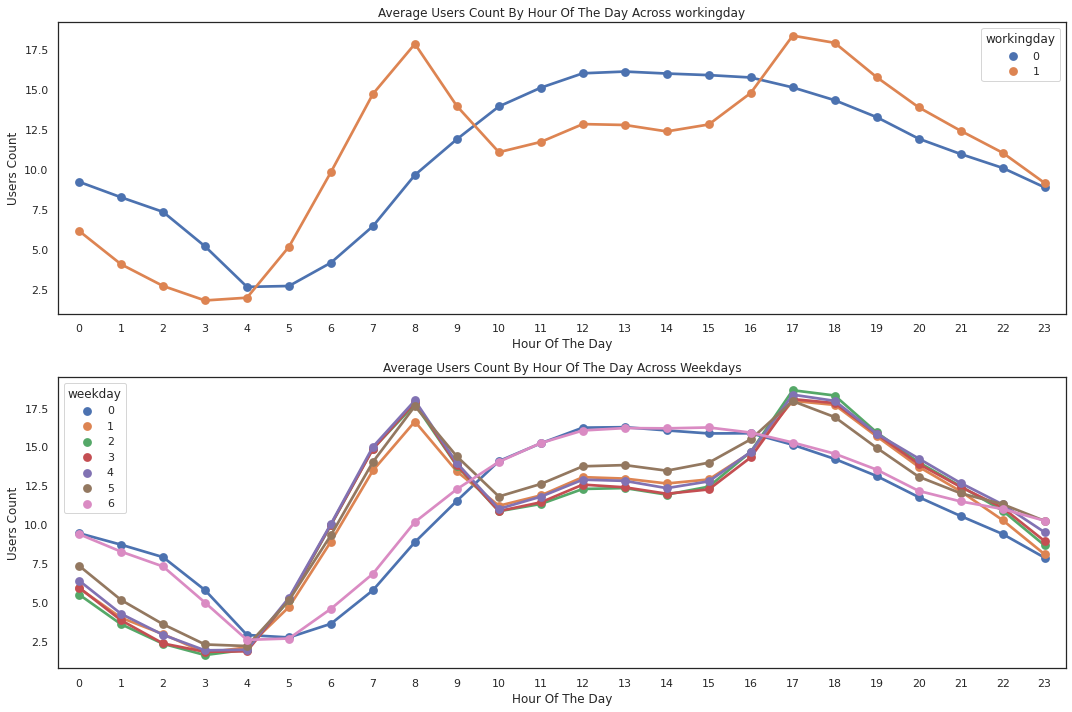

In [ ]:
fig, (ax1, ax2)= plt.subplots(2, 1, figsize=(15,10))

hourAggregated = pd.DataFrame(data.groupby(["hr","workingday"],sort=True)["cnt_box"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hr"], y=hourAggregated["cnt_box"],hue=hourAggregated["workingday"], data=hourAggregated, join=True,ax=ax1)
ax1.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across workingday",label='big')

hourAggregated = pd.DataFrame(data.groupby(["hr","weekday"],sort=True)["cnt_box"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hr"], y=hourAggregated["cnt_box"], hue=hourAggregated["weekday"], data=hourAggregated, join=True, ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count', title="Average Users Count By Hour Of The Day Across Weekdays", label='big')

plt.tight_layout()
plt.show()

In [ ]:
data.drop(columns=["weekday"], inplace=True)

# Feature engineering

## hour

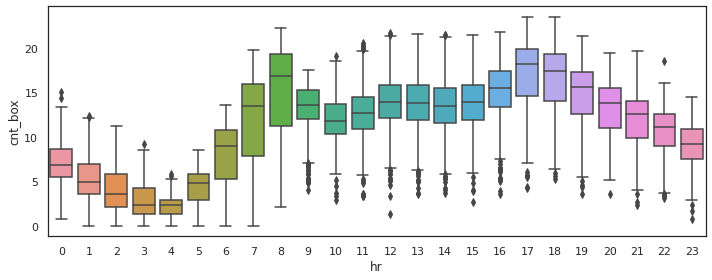

In [ ]:
fig = plt.figure(figsize=(10, 4))
sns.boxplot(data=data, y="cnt_box", x="hr", orient="v")
plt.tight_layout()
plt.show()

In [ ]:
# We will create 4 degree: first(0), second(1), third(2), fourth(3)
bin_first = [0, 1, 2, 3, 4, 5]
bin_second = [6, 22, 23]
bin_third = [7, 9, 10, 11, 12, 13, 14, 15, 20, 21]
bin_fourth = [8, 16, 17, 18, 19]

data.loc[:, 'degree'] = 0
data.loc[data["hr"].isin(bin_second), 'degree'] = 1
data.loc[data["hr"].isin(bin_third), 'degree'] = 2
data.loc[data["hr"].isin(bin_fourth), 'degree'] = 3

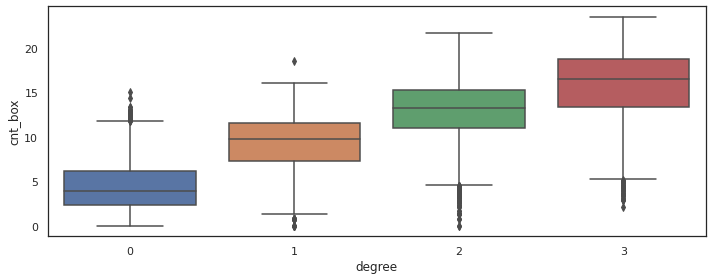

In [ ]:
fig = plt.figure(figsize=(10, 4))
sns.boxplot(data=data, y="cnt_box", x="degree", orient="v")
plt.tight_layout()
plt.show()

It will work well for the linear model because we created a linear relation between hour degree and total count. But for tree-based models, linearity is not a necessary assumption. So we can use the following transformation

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


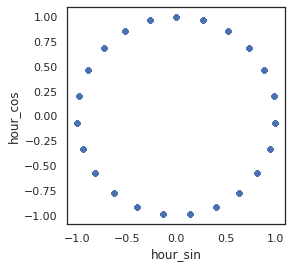

In [ ]:
data['hour_sin'] = np.sin(2 * np.pi * data['hr']/23.0)
data['hour_cos'] = np.cos(2 * np.pi * data['hr']/23.0)
ax = data.plot.scatter('hour_sin', 'hour_cos').set_aspect('equal')

In [ ]:
data.drop(columns=["hr"], inplace=True)

## Month

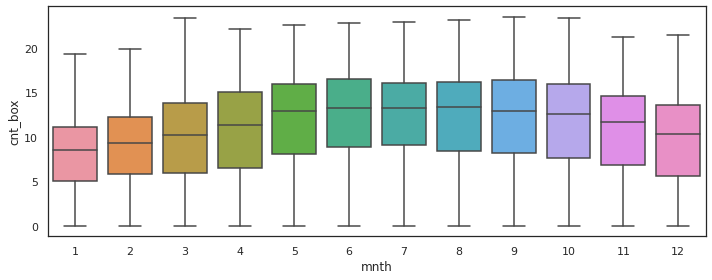

In [ ]:
fig = plt.figure(figsize=(10, 4))
sns.boxplot(data=data, y="cnt_box", x="mnth", orient="v")
plt.tight_layout()
plt.show()

In [ ]:
# We will create 3 groups: first(0), second(1), third(2)
bin_first = [1, 2, 12]
bin_second = [4, 11]
bin_third = [5, 6, 7, 8, 9, 10]

data.loc[:, 'mnth_group'] = 0
data.loc[data["mnth"].isin(bin_second), 'mnth_group'] = 1
data.loc[data["mnth"].isin(bin_third), 'mnth_group'] = 2

data.drop(columns=["mnth"], inplace=True)

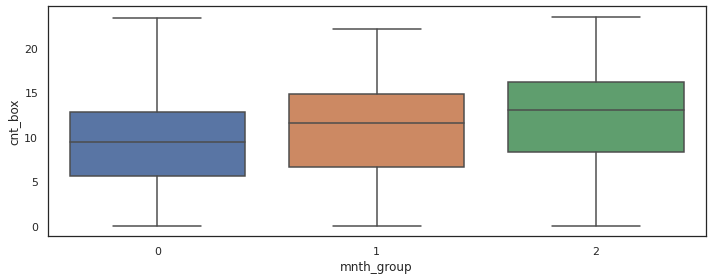

In [ ]:
fig = plt.figure(figsize=(10, 4))
sns.boxplot(data=data, y="cnt_box", x="mnth_group", orient="v")
plt.tight_layout()
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


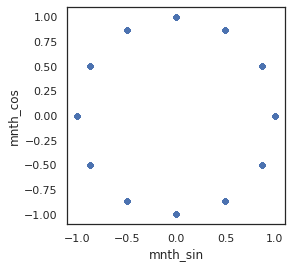

In [ ]:
data['mnth_sin'] = np.sin(2 * np.pi * data['mnth']/12.0)
data['mnth_cos'] = np.cos(2 * np.pi * data['mnth']/12.0)
ax = data.plot.scatter('mnth_sin', 'mnth_cos').set_aspect('equal')

# Data Preparation

In [25]:
data = pd.read_csv("hour.csv", index_col="instant")
data.loc[:, "dteday"] = pd.to_datetime(data.loc[:, "dteday"])
dates = data.loc[:, ["dteday"]]
data.drop(columns=["dteday", "yr"], inplace=True)
data.drop(columns=["weekday", "season"], inplace=True)

Сategories = ["holiday", "workingday", "weathersit"]
for var in Сategories:
    data.loc[:, var] = data.loc[:, var].astype("category")

y_data_1 = data.loc[:, ['casual']]
y_data_2 = data.loc[:, ['registered']]
y_data_3 = data.loc[:, ['cnt']]

x_data = data.drop(columns=['casual', 'registered', 'cnt'])

# We will create 3 groups: first(0), second(1), third(2)
bin_first = [1, 2, 12]
bin_second = [4, 11]
bin_third = [5, 6, 7, 8, 9, 10]

x_data.loc[:, 'mnth_group'] = 0
x_data.loc[x_data["mnth"].isin(bin_second), 'mnth_group'] = 1
x_data.loc[x_data["mnth"].isin(bin_third), 'mnth_group'] = 2

x_data['mnth_sin'] = np.sin(2 * np.pi * data['mnth']/12.0)
x_data['mnth_cos'] = np.cos(2 * np.pi * data['mnth']/12.0)

x_data.drop(columns=["mnth"], inplace=True)

# We will create 4 degree: first(0), second(1), third(2), fourth(3)
bin_first = [0, 1, 2, 3, 4, 5]
bin_second = [6, 22, 23]
bin_third = [7, 9, 10, 11, 12, 13, 14, 15, 20, 21]
bin_fourth = [8, 16, 17, 18, 19]

x_data.loc[:, 'degree'] = 0
x_data.loc[x_data["hr"].isin(bin_second), 'degree'] = 1
x_data.loc[x_data["hr"].isin(bin_third), 'degree'] = 2
x_data.loc[x_data["hr"].isin(bin_fourth), 'degree'] = 3

x_data['hour_sin'] = np.sin(2 * np.pi * x_data['hr']/23.0)
x_data['hour_cos'] = np.cos(2 * np.pi * x_data['hr']/23.0)

x_data.drop(columns=["hr"], inplace=True)

x_train, x_test = x_data.iloc[:int(len(x_data)*0.85)], x_data.iloc[int(len(x_data)*0.85):]
y_train_1, y_test_1 = y_data_1.iloc[:int(len(y_data_1)*0.85)], y_data_1.iloc[int(len(y_data_1)*0.85):]
y_train_2, y_test_2 = y_data_2.iloc[:int(len(y_data_2)*0.85)], y_data_2.iloc[int(len(y_data_2)*0.85):]
y_train_3, y_test_3 = y_data_3.iloc[:int(len(y_data_3)*0.85)], y_data_3.iloc[int(len(y_data_3)*0.85):]

# Pipelines

In [26]:
# cont. vars pipeline: StandardScaler
cont_var_1 = ['atemp', 'hum', 'windspeed']

# ordinal vars pipeline: already encoded
ordinal_var_1 = ['holiday', 'workingday', 'weathersit', 'mnth_group', 'degree']

In [27]:
types = ['lgbm', 'Ridge', 'TreeReg', 'KNN', 'RFR', 'SVM', 'ElasticNet', 
         'Lasso', 'LinearReg', 'Poisson']
estimators_var_1 = []
for model_type in types:
    estimators_var_1.append(pipeline(cont_vars=cont_var_1, ordinal_vars=ordinal_var_1, model_type=model_type))

In [28]:
transformation_for_y_1 = PowerTransformer(method='yeo-johnson', standardize=True)
transformation_for_y_2 = PowerTransformer(method='yeo-johnson', standardize=True)
transformation_for_y_3 = PowerTransformer(method='yeo-johnson', standardize=True)

transformation_for_y_1.fit(y_train_1)
transformation_for_y_2.fit(y_train_2)
transformation_for_y_3.fit(y_train_3)

PowerTransformer()

# Models

## Regression analysis

* What are the most influential features? (1 point)  
* How the temperature and humidity affect rental count rates? (1 point)  
* What is more important: current season or current hour, temperature or feeling temperature? Why? (1 point)

Let's answer those quastions using regression analysis

In [ ]:
x_data["box"] = transformation_for_y_3.transform(y_data_3)
" + ".join(x_data.columns)

In [ ]:
import statsmodels.formula.api as smf

m1 = smf.ols('box ~ holiday + workingday + weathersit + temp + hum + windspeed + mnth_group + degree',
             data=x_data) 
fitted = m1.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    box   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     4500.
Date:                Sun, 03 Oct 2021   Prob (F-statistic):               0.00
Time:                        06:58:56   Log-Likelihood:                -13808.
No. Observations:               17379   AIC:                         2.764e+04
Df Residuals:                   17368   BIC:                         2.772e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.3555      0.025    -

In [ ]:
import statsmodels.formula.api as smf

m1 = smf.ols('box ~ holiday + workingday + weathersit + atemp + hum + windspeed + mnth_group + degree',
             data=x_data) 
fitted = m1.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    box   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     4526.
Date:                Sun, 03 Oct 2021   Prob (F-statistic):               0.00
Time:                        06:58:59   Log-Likelihood:                -13772.
No. Observations:               17379   AIC:                         2.757e+04
Df Residuals:                   17368   BIC:                         2.765e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.4069      0.026    -

Conclusions:
1. atemp is more important than temp.
2. temp got a positive influence on rental count rates
3. hum got a negative influence on rental count rates
4. atemp is the most powerful feature

Durbin-Watson = 0.560, so we can't really rely on our investigation results

In [ ]:
x_data.drop(columns=["box"], inplace=True)

## Quality without parameters optimization

### Casual results

In [ ]:
quality_frame_1 = quality_func(estimators_list=estimators_var_1, y_transformer=transformation_for_y_1, 
                               y_train=y_train_1, y_test=y_test_1, x_train=x_train, x_test=x_test)

### Registered results

In [ ]:
quality_frame_2 = quality_func(estimators_list=estimators_var_1, y_transformer=transformation_for_y_2, 
                               y_train=y_train_2, y_test=y_test_2, x_train=x_train, x_test=x_test)

### Total cnt results

In [ ]:
quality_frame_3 = quality_func(estimators_list=estimators_var_1, y_transformer=transformation_for_y_3, 
                               y_train=y_train_3, y_test=y_test_3, x_train=x_train, x_test=x_test)

In [ ]:
quality_frame_3

,r2_score_train,r2_score_test,mae_train,mae_test
lgbm,0.7855,0.6154,54.9882,88.8911
Ridge,0.6089,0.3847,71.7738,114.154
TreeReg,0.9734,0.4704,8.9772,106.256
KNN,0.8022,0.5763,50.3793,93.6216
RFR,0.942,0.6058,26.636,90.6283
SVM,0.7403,0.5739,58.345,93.5851
ElasticNet,0.0984,-0.0883,113.361,155.982
Lasso,-0.1253,-0.2898,132.118,175.648
LinearReg,0.6089,0.3848,71.7741,114.153
Poisson,0.6022,0.4515,75.0893,108.097


## Parameters tuning and quality

In [ ]:
estimators_var_1 = models_optimization(estimators_list=estimators_var_1, models_types=types, x_train=x_train, y_train=y_train_3, y_transformer=transformation_for_y_3)

optimization of lgbm model
MAE 78.347 params {'model_fitting__min_child_samples': 95, 'model_fitting__n_estimators': 492, 'model_fitting__num_leaves': 57, 'model_fitting__reg_alpha': 10.748389964336562, 'model_fitting__reg_lambda': 0.5231809019230794}
MAE 77.649 params {'model_fitting__min_child_samples': 84, 'model_fitting__n_estimators': 373, 'model_fitting__num_leaves': 29, 'model_fitting__reg_alpha': 0.1530929513192362, 'model_fitting__reg_lambda': 12.8213860620624}
MAE 76.773 params {'model_fitting__min_child_samples': 72, 'model_fitting__n_estimators': 517, 'model_fitting__num_leaves': 11, 'model_fitting__reg_alpha': 1.0088338259661531, 'model_fitting__reg_lambda': 11.237567661049235}
MAE 77.964 params {'model_fitting__min_child_samples': 78, 'model_fitting__n_estimators': 440, 'model_fitting__num_leaves': 48, 'model_fitting__reg_alpha': 0.10973550119216516, 'model_fitting__reg_lambda': 30.988248973241504}
MAE 77.130 params {'model_fitting__min_child_samples': 74, 'model_fitting_

1. **best params for model SVM**:    
    1.1. 'C' =  1  
    1.2. 'gamma' = 0.055 
2. **best params for model RFR**:  
    2.1. 'max_depth' = 10  
    2.2. 'max_features': "auto"   
    2.3. 'min_samples_split': 6.0   
    2.4. 'n_estimators': 125.0  
3. **best params for model KNN**:  
    3.1. 'n_neighbors' = 10  
    3.2. 'weights': "uniform"  
4. **best params for model TreeReg**:  
    4.1. 'max_depth' = 7  
    4.2. 'max_features': "auto"  
    4.3. 'min_samples_split' = 4   
5. **best params for model Ridge**:  
    5.1. 'alpha' = 0
6. **best params for model lgbm**:  
    6.1. 'min_child_samples' = 20  
    6.2. 'n_estimators': 344  
    6.3. 'num_leaves': 10.0   
    6.4. 'reg_alpha': 0.5  
    6.5. 'reg_lambda' = 1.25

In [ ]:
for model, type_ in zip(estimators_var_1, types)
    with open(f"/content/gdrive/MyDrive/EPAM/Week 9. Advanced Regression/HW/models/{type_}.pkl", "wb") as f:
        pickle.dump(model, f)

In [ ]:
estimators_list = []
for type_ in types:
    with open(f"/content/gdrive/MyDrive/EPAM/Week 9. Advanced Regression/HW/models/{type_}.pkl", "rb") as f:
        model = pickle.load(f)
    estimators_list.append(model)

### Casual results

In [ ]:
types = ['lgbm', 'Ridge', 'TreeReg', 'KNN', 'RFR', 'SVM', 'ElasticNet', 
         'Lasso', 'LinearReg', 'Poisson']
estimators_var_1 = []
for model_type in types:
    estimators_var_1.append(tuned_pipeline(cont_vars=cont_var_1, ordinal_vars=ordinal_var_1, model_type=model_type))

In [ ]:
quality_frame_1 = quality_func(estimators_list=estimators_var_1, y_transformer=transformation_for_y_1, 
                               y_train=y_train_1, y_test=y_test_1, x_train=x_train, x_test=x_test)

In [ ]:
quality_frame_1

,r2_score_train,r2_score_test,mae_train,mae_test
lgbm,0.7838,0.6846,13.3162,16.2716
Ridge,0.4613,0.3555,18.4305,21.1503
TreeReg,0.7248,0.6534,14.6167,16.8807
KNN,0.7383,0.6258,13.3262,17.2037
RFR,0.811,0.6828,12.2585,15.9893
SVM,0.7099,0.658,14.3268,16.2522
ElasticNet,-0.1105,-0.1135,28.621,29.3759
Lasso,-0.1733,-0.1555,30.393,31.035
LinearReg,0.4613,0.3555,18.4305,21.1503
Poisson,0.5174,0.4854,18.8715,19.902


### Registered results

In [ ]:
quality_frame_2 = quality_func(estimators_list=estimators_var_1, y_transformer=transformation_for_y_2, 
                               y_train=y_train_2, y_test=y_test_2, x_train=x_train, x_test=x_test)

In [ ]:
quality_frame_2

,r2_score_train,r2_score_test,mae_train,mae_test
lgbm,0.7543,0.5847,47.7677,78.3904
Ridge,0.5919,0.3548,59.9531,98.5715
TreeReg,0.7073,0.5222,51.6925,83.7673
KNN,0.7499,0.5576,46.1745,80.9858
RFR,0.7739,0.5859,45.0175,78.5367
SVM,0.6965,0.521,51.1128,83.6149
ElasticNet,0.1036,-0.1142,89.5976,133.115
Lasso,-0.1186,-0.3092,104.874,149.035
LinearReg,0.5919,0.3548,59.9531,98.5712
Poisson,0.6173,0.457,61.5479,91.4512


### Total cnt results

In [ ]:
quality_frame_3 = quality_func(estimators_list=estimators_var_1, y_transformer=transformation_for_y_3, 
                               y_train=y_train_3, y_test=y_test_3, x_train=x_train, x_test=x_test)

In [ ]:
quality_frame_3

,r2_score_train,r2_score_test,mae_train,mae_test
lgbm,0.7763,0.609,56.1897,89.4584
Ridge,0.6089,0.3848,71.774,114.153
TreeReg,0.7311,0.5705,60.9518,93.9053
KNN,0.7715,0.5915,54.7157,91.852
RFR,0.7946,0.611,52.7937,89.5859
SVM,0.7219,0.5617,60.5321,94.1731
ElasticNet,0.0984,-0.0883,113.361,155.982
Lasso,-0.1253,-0.2898,132.118,175.648
LinearReg,0.6089,0.3848,71.7741,114.153
Poisson,0.6022,0.4515,75.0893,108.097


## Best Model

### First-second year

Considering the best model, train it on the first year and validate on the second year. The results are better or worse? Why? (1 point)

In [29]:
estimator_best = best_pipeline(cont_vars=cont_var_1, ordinal_vars=ordinal_var_1)

In [30]:
x_train, x_test = x_data.iloc[:int(len(x_data)*0.5)], x_data.iloc[int(len(x_data)*0.5):]
y_train_1, y_test_1 = y_data_1.iloc[:int(len(y_data_1)*0.5)], y_data_1.iloc[int(len(y_data_1)*0.5):]
y_train_2, y_test_2 = y_data_2.iloc[:int(len(y_data_2)*0.5)], y_data_2.iloc[int(len(y_data_2)*0.5):]
y_train_3, y_test_3 = y_data_3.iloc[:int(len(y_data_3)*0.5)], y_data_3.iloc[int(len(y_data_3)*0.5):]

  r2_score_train r2_score_test mae_train mae_test
0         0.8232        0.4755   38.0985  103.298


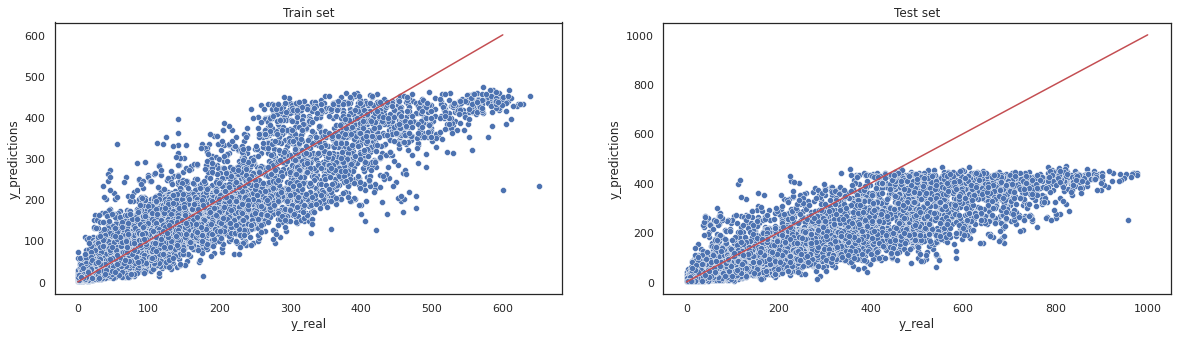

DurbinWatson coef for train = 1.23
DurbinWatson coef for test = 0.422


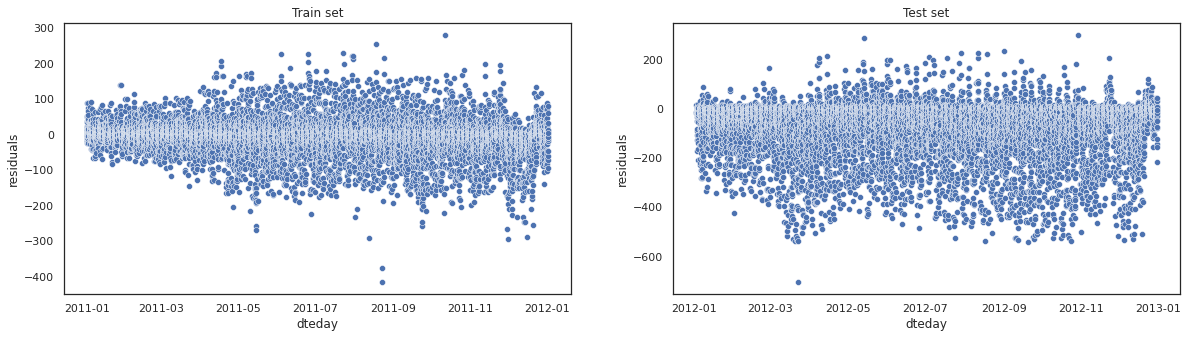

In [31]:
func_res(estimator=estimator_best, x_train=x_train, x_test=x_test, y_train=y_train_3, y_test=y_test_3, 
         dates=dates, y_transformer=transformation_for_y_3)

Okay, as we can see here, the quality of the model is worse than in the previous case. There are quite a few factors that can influence the results. The first one is that we can see a trend in our target variable. So the conditional expectation of the target variable in the first year is not equal to it in the second year. And the other problem is that lgbm is a tree-based algorithm, so it means that it is not able to capture the trend even if the conditional expectation would be equal on each point it still would not figure out that task. that's why we didn't see any predictions that is higher than 500 in a test set. Also we've got huge aotucorrelation in our residuals, that basicly means that there are planty of thing to do

### Multitarget

Considering the best model, train it on the first year with multitarget (casual, registered) and validate on the second year. Analyze both targets independently. Then use a sum of both targets to predict cnt on the second year. Estimate the quality. Are the results better or worse in comparison with the previous step? Why? (1 point)

In [34]:
multi = MultiOutputRegressor(estimator=estimator_best)
y_test_3["preds"] = multi.predict(x_test).sum(axis=1)
y_test_3["resid"] = y_test_3["preds"] - y_test_3["cnt"]

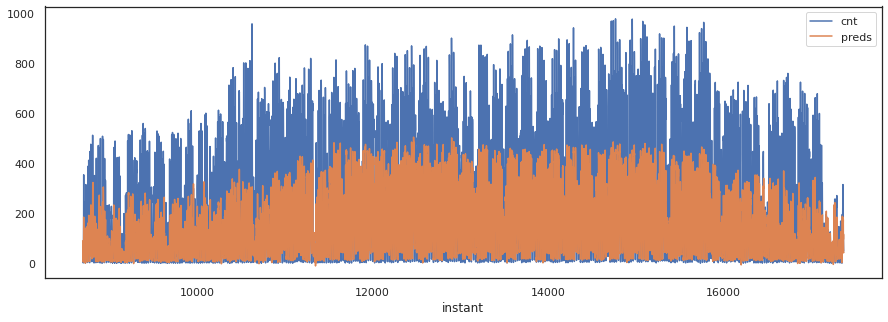

In [54]:
y_test_3.loc[:, ["cnt", "preds"]].plot(figsize=(15, 5))
plt.show()

Fitting of residuals by Laplace distribution: fitted mean = -50.699, fitted std = 86.713
Fitting of residuals by Normal distribution: fitted mean = -84.584, fitted std = 117.763


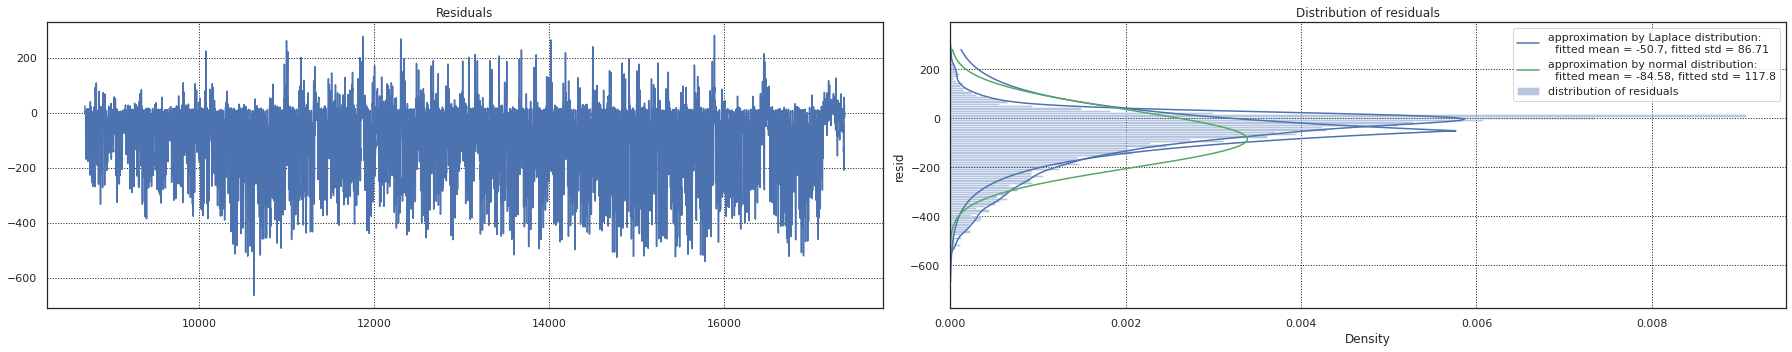

In [51]:
resid_analysis(resid=y_test_3["resid"])

The distribution of errors is highly skewed, the model underestimates the predictions

In [52]:
# r2
r2_score_test = np.round(r2_score(y_test_3["cnt"].dropna(), y_test_3["preds"]), 4)
# mae
mae_test = np.round(mean_absolute_error(y_test_3["cnt"].dropna(), y_test_3["preds"]), 4)

print("exo-linear quality:")
print(f"r2 score test {r2_score_test}")
print(f"mae test {mae_test}")

exo-linear quality:
r2 score test 0.5193
mae test 98.6533


The result is significantly worse. Maybe because of double underestimation?)